In [19]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [20]:
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]

In [21]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import deque
import pickle

import numpy as np

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [23]:
env_id = "CarRacing-v2"

# Create the env
env = gym.make(env_id, continuous=False, domain_randomize=False)

# Create the evaluation env
eval_env = gym.make(env_id, continuous=False, domain_randomize=False, render_mode="rgb_array")

# Get the state space and action space
n_actions = env.action_space.n

n_frames = 4

In [24]:
class Policy(nn.Module):
    def __init__(self, n_frames, n_actions, hidden_size, img_size=(64,64), device=torch.device('cpu')):
        super(Policy, self).__init__()
        self.hidden_size = hidden_size
        self.n_frames = n_frames
        self.conv1 = nn.Conv2d(n_frames, hidden_size, 7)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, 5)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_actions)
        self.gs = transforms.Grayscale()
        self.rs = transforms.Resize(img_size)
        self.device = device

    def preproc_state(self, state):
        # State Preprocessing
        state = state[:83,:].transpose(2,0,1) #Torch wants images in format (channels, height, width)
        state = torch.from_numpy(state)
        state = self.gs(state) # grayscale
        state = self.rs(state) # resize
        return state/255 # normalize

    def forward(self, x):
        # Convolutions
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Global Max Pooling
        batch_size = x.shape[0]
        x = x.reshape(batch_size, self.hidden_size, -1).max(axis=2).values

        # Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

    def act(self, states, exploration=True):
        # Stack 4 states
        state = torch.vstack([self.preproc_state(state) for state in states]).unsqueeze(0).to(self.device)

        # Get Action Probabilities
        probs = self.forward(state).cpu()

        # Return Action and LogProb
        action = probs.argmax(-1)
        log_prob = None
        if exploration:
            m = Categorical(probs)
            action = m.sample()
            log_prob = m.log_prob(action)
        return action.item(), log_prob

    def to(self, device):
        ret = super().to(device)
        ret.device = device
        return ret

In [25]:
MAX_PATIENCE = 100 # Maximum consecutive steps with negative reward

In [26]:
def evaluate_agent(env, n_eval_episodes, policy):
    episode_rewards = []

    for episode in range(n_eval_episodes):
        state = env.reset() # state reset

        # perform noop for 60 steps (noisy start)
        for i in range(60):
            state,_,_,_,_ = env.step(0)


        done = False

        # stats
        total_rewards_ep = 0
        negative_reward_patience = MAX_PATIENCE

        # state
        states = deque(maxlen=4)
        for i in range(n_frames):
            states.append(state)

        while not done:
            # perform action
            action, _ = policy.act(states, exploration=False)

            # As in practical 4, we do not consider "truncated" (i.e., reaching the max number of steps)
            # as a termination condition
            state, reward, done, _, _ = env.step(action)
            states.append(state)

            # handle patience
            if reward >=0:
                negative_reward_patience = MAX_PATIENCE
            else:
                negative_reward_patience -= 1
                if negative_reward_patience == 0:
                    done = True
            if done: reward = -100

            # stats
            total_rewards_ep += reward

            if done:
                break

        # stats
        episode_rewards.append(total_rewards_ep)

    # stats
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [27]:
def reinforce(policy, optimizer, n_training_episodes=50, gamma=0.99, print_every=10):
    # stats
    scores_deque = deque(maxlen=100)

    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = [] # stores log probs during episode
        rewards = [] # stores rewards during episode

        # init episode
        state = env.reset()
        for i in range(60):
            state,_,_,_,_ = env.step(0)
        done = False

        negative_reward_patience = MAX_PATIENCE
        states = deque(maxlen=4)
        for i in range(n_frames):
            states.append(state)


        while not done:
            action, log_prob = policy.act(states)

            saved_log_probs.append(log_prob)

            # As in practical 4, we do not consider "truncated" (i.e., reaching the max number of steps)
            # as a termination condition
            state, reward, done, _, _ = env.step(action)

            states.append(state)

            if reward >=0:
                negative_reward_patience = MAX_PATIENCE
            else:
                negative_reward_patience -= 1
                if negative_reward_patience == 0:
                    done = True
            if done: reward = -100

            rewards.append(reward)

            if done:
                break
        scores_deque.append(sum(rewards))


        rewards = np.array(rewards)
        discounts = np.power(gamma, np.arange(len(rewards)))

        policy_loss = 0
        for t in range(len(rewards)):
            G = (discounts[:len(rewards)-t]*rewards[t:]).sum()
            policy_loss += -(gamma**t)*G*saved_log_probs[t]
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print(f'''Episode {i_episode}
                    \tAverage Score: {np.mean(scores_deque)}
                    \tLast Score: {rewards.sum()}
                    \tEval Score: {evaluate_agent(eval_env,5,policy)}''')
            torch.save(policy, 'model.pt')


In [28]:
policy = Policy(n_frames, n_actions, 32).to(device)
policy = policy.to(device)

In [29]:
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

In [30]:
reinforce(policy, optimizer)

C:\Users\Michele\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 10
                    	Average Score: -120.45986470365558
                    	Last Score: -125.75862068965527
                    	Eval Score: (-109.89999999999998, 0.0)
Episode 20
                    	Average Score: -124.14122556530836
                    	Last Score: -118.48403041825088
                    	Eval Score: (-109.89999999999998, 0.0)
Episode 30
                    	Average Score: -124.1582052119393
                    	Last Score: -114.89099099099094
                    	Eval Score: (-109.89999999999998, 0.0)
Episode 40
                    	Average Score: -129.07855424136937
                    	Last Score: -138.95055762081853
                    	Eval Score: (-109.89999999999998, 0.0)
Episode 50
                    	Average Score: -132.1413512250686
                    	Last Score: -120.75135135135133
                    	Eval Score: (-109.89999999999998, 0.0)


In [31]:
policy.device


device(type='cpu')

## Test

In [32]:
policy = torch.load('model.pt', map_location=device)
policy = policy.to(device)
policy.eval()

Policy(
  (conv1): Conv2d(4, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=5, bias=True)
  (gs): Grayscale(num_output_channels=1)
  (rs): Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
)

In [33]:
from matplotlib import animation
import matplotlib.pyplot as plt

def save_frames_as_gif(frames, path='./', filename='REINFORCE.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [34]:
def play_agent(env, policy):
    total_reward = 0
    state = env.reset()
    frames_gif=[]
    for i in range(60):
        state,_,_,_,_ = env.step(0)
    step = 0
    done = False
    negative_reward_patience = MAX_PATIENCE
    states = deque(maxlen=4)
    for i in range(policy.n_frames):
        states.append(state)
    while not done:
        
        action, _ = policy.act(states, exploration=False)
        new_state, reward, done, _, _ = env.step(action)
        states.append(new_state)
        if reward >=0:
            negative_reward_patience = MAX_PATIENCE
        else:
            negative_reward_patience -= 1
            if negative_reward_patience == 0:
                done = True
        if done:
            reward = -100
        total_reward += reward
        frames_gif.append(env.render())
        if done:
            break
        state = new_state
    save_frames_as_gif(frames_gif)
    print("Total Reward:", total_reward)

MovieWriter imagemagick unavailable; using Pillow instead.


Total Reward: -109.89999999999998


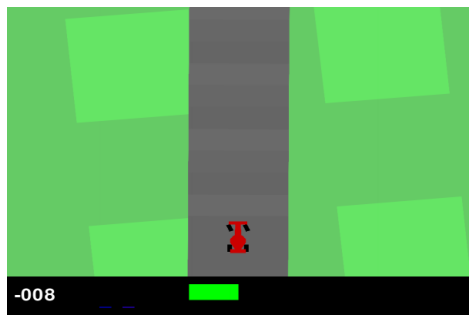

In [35]:
play_agent(eval_env, policy)